# Eye blinks with EEG data

**Authors**:

 - Pablo Castañeda pablo@saturdays.ai | [@Smart_Sapiens [tw]](https://twitter.com/Smart_Sapiens)

---

_This code is Open Source, released under a GPL License._


We will be using a 16-ch, wet [Bitbrain](https://bitbrain.com) EEG headset like this one:

<img src="assets/bitbrain-eeg-headset.jpg" alt="Bitbrain's EEG headset" style="width: 1024px;"/>

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import butter, ellip, cheby1, cheby2, lfilter, freqs,iirfilter

import numpy.fft as fft
import matplotlib.mlab as mlab

%matplotlib inline

In [9]:
df = pd.read_csv("data/4-artifacts-blink-jaw-eyesleft-eyesright-1-min-sequences-BBT-E16-AAA005-2019-11-29_18-22-04/EEG.csv")

In [10]:
starting_seconds = 12.52
samples_per_second = 256

starting_sample = int(starting_seconds * samples_per_second)

seconds_per_training_label = 10
samples_per_training_label = seconds_per_training_label * samples_per_second

first_label_start = starting_sample
second_label_start = starting_sample + samples_per_training_label
third_label_start = second_label_start + samples_per_training_label
third_label_end = third_label_start + samples_per_training_label

In [11]:
for i, row in df.iterrows():
    if first_label_start <= i <= second_label_start:
        df.at[i, 'label'] = "left"
        df.at[i, 'label_code'] = 1
    elif second_label_start <= i <= third_label_start:
        df.at[i, 'label'] = "right"
        df.at[i, 'label_code'] = 2
    elif third_label_start <= i <= third_label_end:
        df.at[i, 'label'] = "rest"
        df.at[i, 'label_code'] = 0
    else:
        df.at[i, 'label'] = "none"
        df.at[i, 'label_code'] = -1

In [12]:
df["label_code"] = df["label_code"].astype(int)

In [14]:
df.to_pickle("data/4-artifacts-blink-jaw-eyesleft-eyesright-1-min-sequences-BBT-E16-AAA005-2019-11-29_18-22-04/labelled-eeg.pkl")

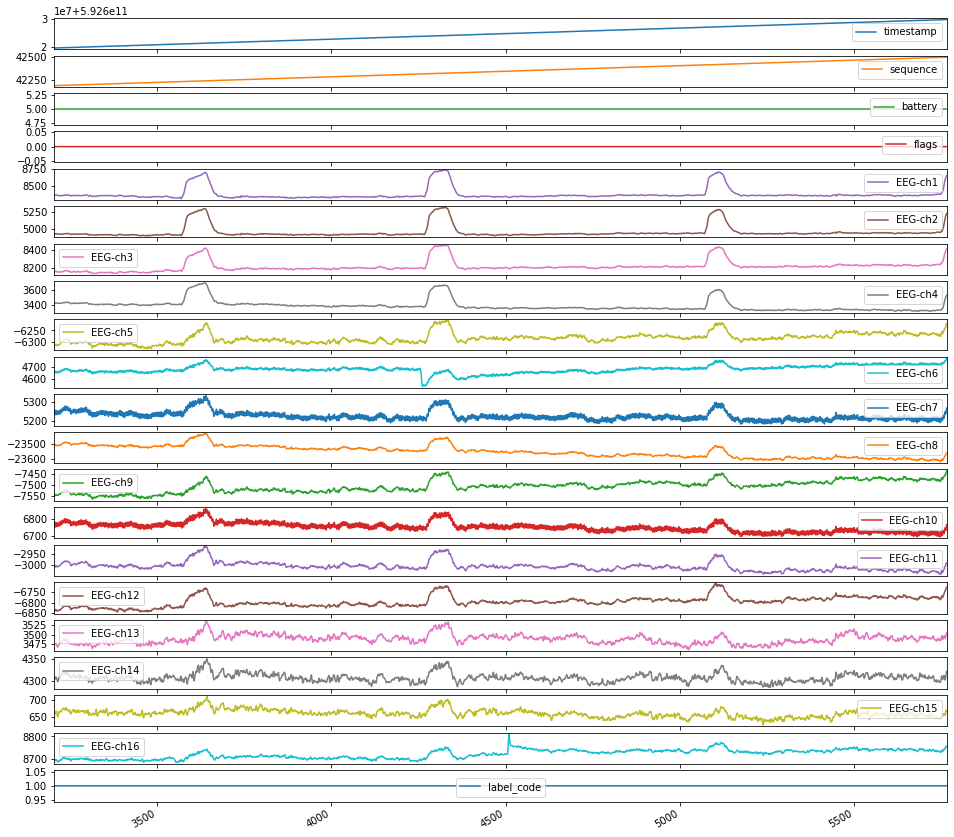

In [15]:
df.loc[df['label'] == "left"].plot(subplots=True, figsize=(16, 16));

Preprocessing

In [29]:
class Kiral_Korek_Preprocessing():
    def __init__(self, path, 
                 name_channels=["Fp1", "Fp2", "Af3", "Af4", "C3", "C1", "C2", "C4", "Cp3", "Cp1", "Cp2", "Cp4", "P7", "01", "02", "P8"]):
        self.path = path
        self.sample_rate = 256 #Default sampling rate for BitBrain Headset
        self.name_channel = name_channels

    def load_data_BCI(self, list_channels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]):
        """
        list_channels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
        name_channels=["Fp1", "Fp2", "Af3", "Af4", "C3", "C1", "C2", "C4", "Cp3", "Cp1", "Cp2", "Cp4", "P7", "01", "02", "P8"]
        Load the data from Bitbrain csv file

        Input:
            list_channel: lists of channels to use
        
        """
        self.number_channels = len(list_channels)
        self.list_channels = list_channels
        
        # load raw data into numpy array
        # load raw data into pandas dataframe
        #self = pd.read_csv(self.path, sep=',', index_col=list_channels ,header=None)

        self.raw_eeg_data = np.loadtxt(self.path, 
                                       delimiter=',',
                                       skiprows=7,
                                       usecols=list_channels)

        #expand the dimmension if only one channel             
        if self.number_channels == 1:
            self.raw_eeg_data = np.expand_dims(self.raw_eeg_data, 
                                                          axis=1)
            
        
        
    def initial_preprocessing(self, bp_lowcut =1, bp_highcut =70, bp_order=5,
                          notch_freq_Hz  = [60.0, 120.0], notch_order=2):
       """
       Filters the data by applying
       - An SL filter
       - A zero-phase Butterworth bandpass was applied from 1 – 70 Hz. 
       - A 60-120 Hz notch filter to suppress line noise
      
       
       Input:
           - bp_ lowcut: lower cutoff frequency for bandpass filter
           - bp_highcut: higher cutoff frequency for bandpass filter
           - bp_order: order of bandpass filter
           - notch_freq_Hz: cutoff frequencies for notch fitltering
           - notch_order: order of notch filter

        
        """
       self.nyq = 0.5 * self.sample_rate #Nyquist frequency
       self.low = bp_lowcut / self.nyq
       self.high = bp_highcut / self.nyq
       
       
       #Butter
       b_bandpass, a_bandpass = butter(bp_order, [self.low , self.high], btype='band', analog=True)
       
       
       
       self.bp_filtered_eeg_data = np.apply_along_axis(lambda l: lfilter(b_bandpass, a_bandpass ,l),0,
                                                      self.raw_eeg_data)

       self.notch_filtered_eeg_data = self.bp_filtered_eeg_data
       
       for freq_Hz in notch_freq_Hz: 
            bp_stop_Hz = freq_Hz + float(notch_order)*np.array([-1, 1])  # set the stop band
            b_notch, a_notch = butter(notch_order, bp_stop_Hz/self.nyq , 'bandstop')
            self.notch_filtered_eeg_data = np.apply_along_axis(lambda l: lfilter(b_notch, a_notch,l),0,
                                                              self.notch_filtered_eeg_data)
       self.corrected_eeg_data = self.notch_filtered_eeg_data
       
       #self.corrected_eeg_data = self.raw_eeg_data


    def convert_to_freq_domain(self, data, NFFT = 250, FFTstep = 1):
        
        """
        
        Computes a spectogram via an FFT
        
        Input:
            - data: data to draw the spectogram on
            - NFFT: The number of data points used in each block
            - FFTstep: Length of the signal you want to calculate the Fourier transform of.
       
        Return:
            - list_spec_PSDperBin: list of periograms
                - 2D where columns are the periodograms of successive segments
            - list_freqs: The frequencies corresponding to the rows in spectrum
            - list_t_spec: The times corresponding the columns in spectrum
        
       """
        
        FFTstep = FFTstep   # do a new FFT every FFTstep data points
        overlap = NFFT - FFTstep  # half-second steps
    
        list_spec_PSDperHz,list_spec_PSDperBin, list_freqs, list_t_spec= [], [], [], []
        

        for filtered in data.T:
            spec_PSDperHz, freqs, t_spec = mlab.specgram(
                                           np.squeeze(filtered),
                                           NFFT=NFFT,
                                           window=mlab.window_hanning,
                                           Fs=self.sample_rate,
                                           noverlap=overlap
                                           ) 
            spec_PSDperBin = spec_PSDperHz * self.sample_rate / float(NFFT)  # convert to "per bin"
            list_spec_PSDperHz.append(spec_PSDperHz)
            list_spec_PSDperBin.append(spec_PSDperBin)
            list_freqs.append(freqs)
            list_t_spec.append(t_spec)
        
        return (np.array(list_spec_PSDperBin), np.array(list_freqs), np.array(list_t_spec))
    
            
    

    def plots(self, num_channels=16):
        """
       
        Plot the raw and filtered data 
        
        Input:
            - num_channels: number of channels to plot
        
        """

        fig = plt.figure()
        for channel in range(num_channels):  
            #fig = plt.figure()

            #fig.suptitle(self.name_channel[channel])
    
            self.t_sec = np.array(range(0, self.raw_eeg_data[:,channel].size)) / self.sample_rate
            
            ax1 = plt.subplot(221)
            plt.plot(self.t_sec, self.raw_eeg_data[:,channel],label=self.name_channel[channel])
            plt.ylabel('EEG (uV)')
            plt.xlabel('Time (sec)')
            plt.title('Raw')
            plt.xlim(self.t_sec[0], self.t_sec[-1])
            
            psd,freqs = mlab.psd(np.squeeze(self.raw_eeg_data[:,channel]),NFFT=500,Fs=250)    
            ax2 = plt.subplot(222)
            plt.xlim(self.t_sec[0], self.t_sec[-1])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.ylim(0,10)
            plt.plot(freqs,psd,label=self.name_channel[channel])
            plt.title('PSD of Unfiltered')
            
            
            ax3 = plt.subplot(223)
            plt.plot(self.t_sec, self.corrected_eeg_data[:,channel],label=self.name_channel[channel])
            plt.ylabel('EEG (uV)')
            plt.xlabel('Time (sec)')
            plt.title('Filtered')
            plt.xlim(self.t_sec[0], self.t_sec[-1])
            
            psd,freqs = mlab.psd(np.squeeze(self.corrected_eeg_data[:,channel]),NFFT=500,Fs=250)    
            ax4 = plt.subplot(224)
            plt.xlim(self.t_sec[0], self.t_sec[-1])
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Power')
            plt.ylim(0,0.005)
            plt.plot(freqs,psd,label=self.name_channel[channel])
            plt.title('PSD of filtered')
            
        plt.legend(self.name_channel,loc='upper right', bbox_to_anchor=(0.01, 0.01))
        plt.tight_layout()
        plt.show()

DEMO

/Users/Pablo/Desktop/Virtualenv/lib/python3.7/site-packages/ipykernel_launcher.py:142: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/Pablo/Desktop/Virtualenv/lib/python3.7/site-packages/ipykernel_launcher.py:150: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/Pablo/Desktop/Virtualenv/lib/python3.7/site-packages/ipykernel_launcher.py:159: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous

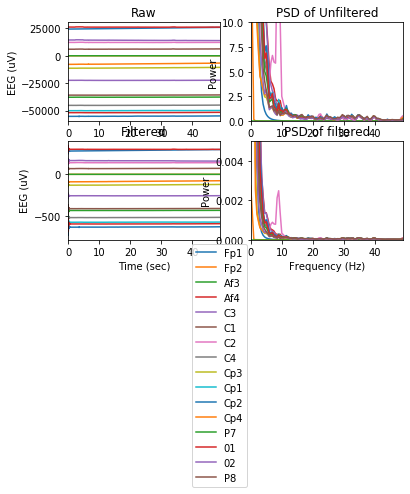

In [30]:
plt.close('all')
path='/Users/Pablo/Desktop/Virtualenv/brain-computer-interfacing/data/'
fname= path +  '3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/EEG.csv'

test4 = Kiral_Korek_Preprocessing(fname)
test4.load_data_BCI()
test4.initial_preprocessing(bp_lowcut =5, bp_highcut =20, bp_order=2)

test4.plots()   